In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pennylane as qml

from sklearn.model_selection import train_test_split

# Direct classes included for easyness
from tensorflow.keras.utils import plot_model
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Model

In [2]:
# load data
np_data = np.load("data/dataRS.npy")

noise_output = np_data[:,-1].reshape(len(np_data),1)
input = np_data[:,:-1]

# split data
test_split = 0.33
x_train, x_test, y_train, y_test = train_test_split(input, noise_output, test_size=test_split, random_state=42)

### Enter your tag as unique id for saving

In [3]:
tag = str("quantumAutoencoder2-21032023")

In [4]:
from pennylane import numpy as np
n_qubits = x_train.shape[1]
x_qubits = 3
compression = 3

dev = qml.device("default.qubit", wires=(n_qubits+x_qubits))

Params in the quantum layer to train: 22
0: ──RY(0.02)──RY(0.42)─╭●──────────────────╭●──────────────────╭●─────────RY(0.24)──────────
1: ──RY(0.50)──RY(0.32)─╰RY(0.82)─╭●────────╰RY(0.81)─╭●────────╰RY(0.29)─╭●─────────RY(0.95)
2: ──RY(0.09)──RY(0.44)───────────╰RY(0.92)─╭●────────╰RY(0.52)─╭●────────╰RY(0.52)─╭●───────
3: ──RY(1.00)──RY(0.17)─────────────────────╰RY(0.56)─╭●────────╰RY(0.06)─╭●────────╰RY(0.66)
4: ──RY(0.24)──RY(0.26)───────────────────────────────╰RY(0.44)───────────╰RY(0.67)──────────
5: ──H───────────────────────────────────────────────────────────────────────────────────────
6: ──────────────────────────────────────────────────────────────────────────────────────────
7: ──────────────────────────────────────────────────────────────────────────────────────────

─────────────────────────────────────┤  <Y>
─────────────────────────────────────┤  <Y>
───RY(0.18)──────────────────────────┤  <Y>
──╭●─────────RY(0.38)───────╭SWAP────┤     
──╰RY(0.75)──RY(0.76)─╭SWAP─│─

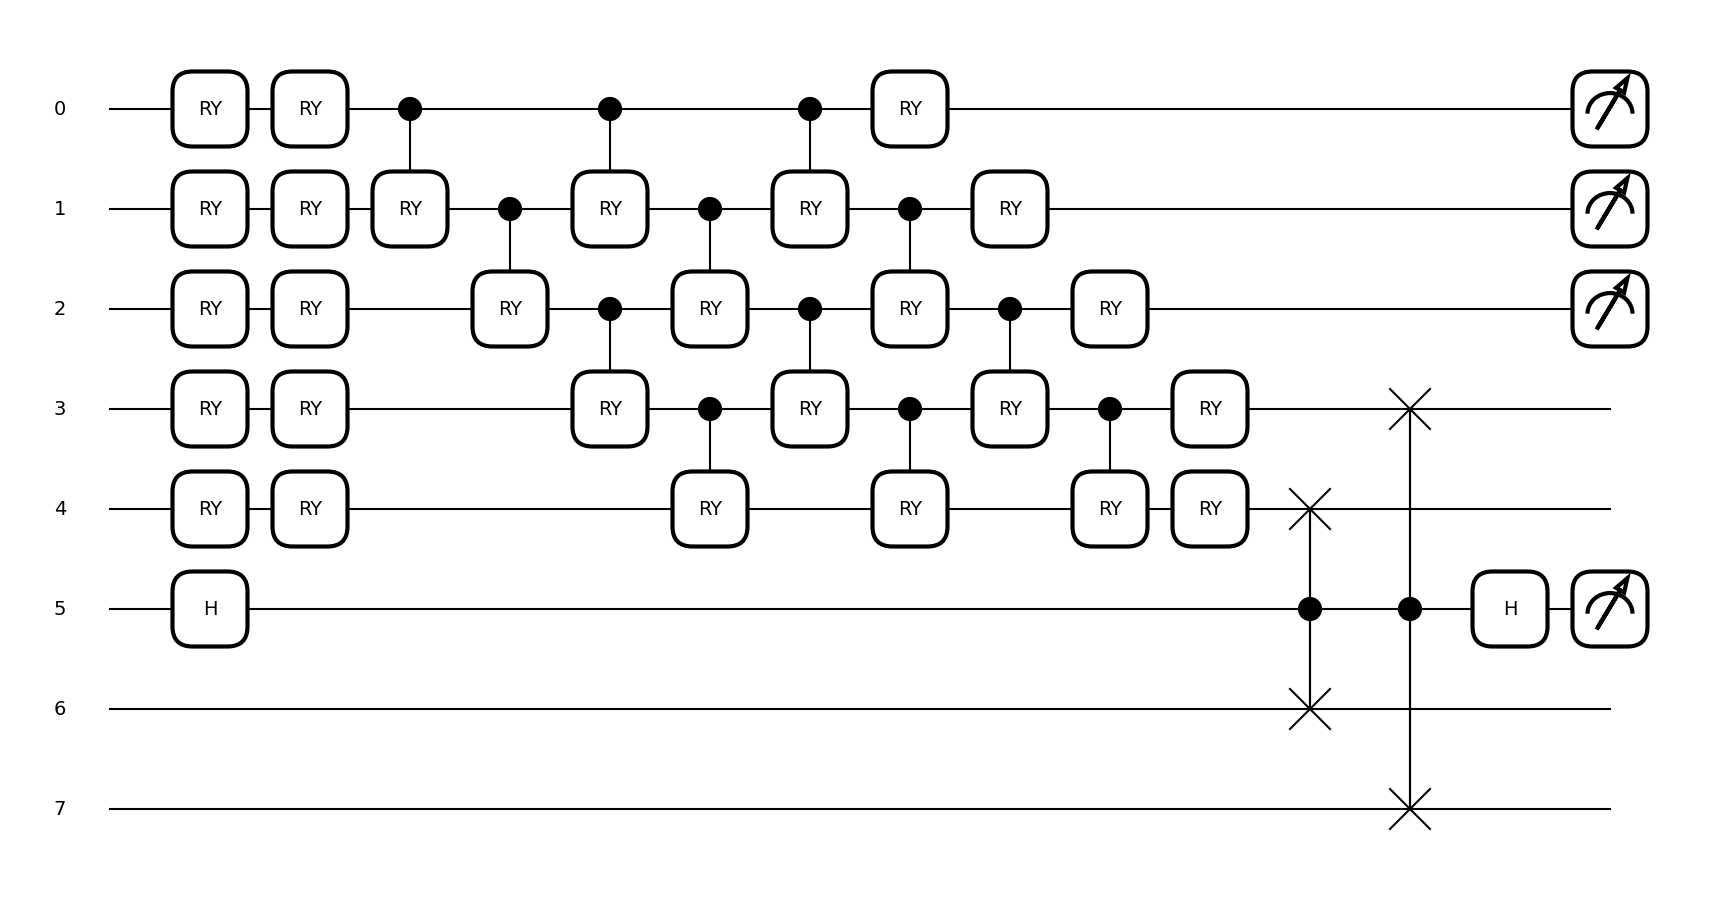

In [5]:
# Encoder
ENC_weight_shapes = {"weight1": (n_qubits),
                 "weight2": (n_qubits-1),
                 "weight3": (n_qubits-1),
                 "weight4": (n_qubits-1),
                 "weight5": (n_qubits)}
nE_qcParams = n_qubits*2+3*(n_qubits-1)
print(f"Params in the quantum layer to train: {nE_qcParams}")



@qml.qnode(dev)
def encoder(inputs, weight1, weight2, weight3, weight4, weight5):
    
    qml.broadcast(qml.RY, wires=range(n_qubits), parameters=inputs, pattern="single")
    
    qml.broadcast(qml.RY, wires=range(n_qubits), parameters=weight1, pattern="single")
    qml.broadcast(qml.CRY, wires=range(n_qubits), parameters=weight2, pattern="chain")
    qml.broadcast(qml.CRY, wires=range(n_qubits), parameters=weight3, pattern="chain")
    qml.broadcast(qml.CRY, wires=range(n_qubits), parameters=weight4, pattern="chain")
    qml.broadcast(qml.RY, wires=range(n_qubits), parameters=weight5, pattern="single")
    
    qml.Hadamard(wires=5)
    qml.CSWAP(wires=[5,6,4])
    qml.CSWAP(wires=[5,7,3])
    qml.Hadamard(wires=5)
    return [qml.expval(qml.PauliY(wires=0)), qml.expval(qml.PauliY(wires=1)), qml.expval(qml.PauliY(wires=2)), qml.expval(qml.PauliZ(wires=5))]
    # return qml.expval(qml.PauliZ(wires=5))

qEncoder = qml.qnn.KerasLayer(encoder, ENC_weight_shapes, output_dim=n_qubits)

# Visualize the quantum circuit
print(qml.draw(encoder)(x_train[0,:],np.random.rand(n_qubits), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1), np.random.rand(n_qubits)))
fig1, ax = qml.draw_mpl(encoder)(x_train[0,:],np.random.rand(n_qubits), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1), np.random.rand(n_qubits))
plt.show()
fig1.savefig("archive/Encoder-"+tag+".png")
fig1.savefig("archive/Encoder-"+tag+".pdf")

In [6]:
#Training
#['mean_squared_error', 'mean_absolute_error','mean_squared_logarithmic_error', 'mean_absolute_percentage_error']

inputLayer = Input(shape=(x_train.shape[1],))
encoded = qEncoder(inputLayer)
# Encoder
encoderModel = Model(inputLayer, encoded)
def cost(y_true, y_pred):
    y_pred = y_pred[:,3]
    squared_difference = tf.square(y_true - y_pred)
    return tf.reduce_mean(squared_difference, axis=-1)
def scheduler(epoch, lr):
    if epoch < 8:
        return lr
    else:
        return lr* tf.math.exp(-0.1)
LearningRateScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="auto", min_delta=0.001, patience=20)

optRMS = tf.keras.optimizers.RMSprop(learning_rate=0.05)

encoderModel.compile(optimizer = optRMS, loss=cost)

In [7]:
encoder_history = encoderModel.fit(x_train,np.ones((y_train.shape)), epochs=50, batch_size=25, validation_split=0.25, callbacks=[EarlyStopping, LearningRateScheduler])

Epoch 1/50
31/31 [==============================] - ETA: 0s - loss: 0.0245

In [ ]:
encoderModel.summary()
encoderModel.save("archive/encoderModelClean-"+tag+".h5")
encoderModel.save_weights("archive/encoderWeightsClean-"+tag+".h5")
config = encoderModel.get_config()
np.save("archive/encoderConfigClean-"+tag+".npy", config)
fig = plt.figure()
plt.plot(encoder_history.history['loss'], lw=4, label='loss')
plt.plot(encoder_history.history['val_loss'], lw=4, label='val_loss')
plt.plot(encoder_history.history['lr'], lw=4, label='lr')
plt.xlabel("epoch", fontsize=16)
plt.legend(fontsize=14)
plt.show()
fig.savefig("archive/historyENC-"+tag+".png")

In [ ]:
encoded_train = encoderModel.predict(x_train)
encoded_train = encoded_train[:,:3]
np.save("data/ENCdata_"+tag+".npy", encoded_train)
print(encoded_train.shape)

In [ ]:
from pennylane import numpy as np
n_qubits = x_train.shape[1]
compression = 3

dev = qml.device("default.qubit", wires=n_qubits)

In [ ]:

# Decoder
DEC_weight_shapes = {"weight1": (n_qubits),
                 "weight2": (n_qubits-1),
                 "weight3": (n_qubits-1),
                 "weight4": (n_qubits-1),
                 "weight5": (n_qubits)}
nD_qcParams = n_qubits*2+3*(n_qubits-1)
print(f"Params in the quantum layer to train: {nD_qcParams}")



@qml.qnode(dev)
def decoder(inputs, weight1, weight2, weight3, weight4, weight5):
    qml.broadcast(qml.RY, wires=range(compression), parameters=inputs, pattern="single")
    
    qml.broadcast(qml.RY, wires=range(n_qubits), parameters=weight1, pattern="single")
    qml.broadcast(qml.CRY, wires=range(n_qubits), parameters=weight2, pattern="chain")
    qml.broadcast(qml.CRY, wires=range(n_qubits), parameters=weight3, pattern="chain")
    qml.broadcast(qml.CRY, wires=range(n_qubits), parameters=weight4, pattern="chain")
    qml.broadcast(qml.RY, wires=range(n_qubits), parameters=weight5, pattern="single")
    
    return [qml.expval(qml.PauliY(wires=i)) for i in range(n_qubits)]

qDecoder = qml.qnn.KerasLayer(decoder, DEC_weight_shapes, output_dim=n_qubits)

# Visualize the quantum circuit
print(qml.draw(decoder)(x_train[0,:3],np.random.rand(n_qubits), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1), np.random.rand(n_qubits)))
fig2, ax = qml.draw_mpl(decoder)(x_train[0,:3],np.random.rand(n_qubits), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1), np.random.rand(n_qubits-1), np.random.rand(n_qubits))
plt.show()
fig2.savefig("archive/Decoder-"+tag+".png")
fig2.savefig("archive/Decoder-"+tag+".pdf")

In [ ]:
#Training
#['mean_squared_error', 'mean_absolute_error','mean_squared_logarithmic_error', 'mean_absolute_percentage_error']

inputLayer = Input(shape=(encoded_train.shape[1],))
decoded = qDecoder(inputLayer)
# Decoder
decoderModel = Model(inputLayer, decoded)
def scheduler(epoch, lr):
    if epoch < 8:
        return lr
    else:
        return lr* tf.math.exp(-0.1)
LearningRateScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="auto", min_delta=0.001, patience=20)

optRMS = tf.keras.optimizers.RMSprop(learning_rate=0.05)

decoderModel.compile(optimizer = optRMS, loss='mean_squared_error', metrics=['mean_absolute_error'])

In [ ]:
print(encoded_train.shape)

In [ ]:
decoder_history = decoderModel.fit(encoded_train, x_train, epochs=50, batch_size=25, validation_split=0.25, callbacks=[EarlyStopping, LearningRateScheduler])

In [ ]:
import numpy as np

def plot_metrics(history):
    n = len(history.history.keys())//2
    fig,axs = plt.subplots(1,n, figsize=(18,5))

    for i,[key,val] in enumerate(history.history.items()):
        axs[i%n].plot(history.history[key], lw=4, label=key.replace("_", " "))
    
    for ax in axs:
        #ax.set_yscale("log")
        ax.set_xlabel("epoch", fontsize=16)
        ax.legend(fontsize=14)
plot_metrics(decoder_history)
decoderModel.summary()

fig = plt.figure()
plt.plot(decoder_history.history['loss'], lw=4, label='loss')
plt.plot(decoder_history.history['val_loss'], lw=4, label='val_loss')
plt.plot(decoder_history.history['lr'], lw=4, label='lr')
plt.xlabel("epoch", fontsize=16)
plt.legend(fontsize=14)
plt.show()
fig.savefig("archive/historyDEC-"+tag+".png")

In [ ]:
#Create a autoencode like in https://blog.keras.io/building-autoencoders-in-keras.html
clear_session()

inputLayer = Input(shape=(x_train.shape[1],))
encoded = encoderModel(inputLayer)
encoded = encoded[:,:3]
decoded = decoderModel(encoded)
autoencoder = Model(inputLayer, decoded)
print(f"Params in all quantum layers to train: {nD_qcParams+nE_qcParams}")
autoencoder.summary()

In [ ]:
#Training
#['mean_squared_error', 'mean_absolute_error','mean_squared_logarithmic_error', 'mean_absolute_percentage_error']

def scheduler(epoch, lr):
    if epoch < 8:
        return lr
    else:
        return lr* tf.math.exp(-0.1)
LearningRateScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", mode="auto", min_delta=0.001, patience=20)

optRMS = tf.keras.optimizers.RMSprop(learning_rate=0.05)

autoencoder.compile(optimizer = optRMS, loss='mean_squared_error', metrics=['mean_absolute_error'])

autoencoder_history = autoencoder.fit(x_train[:334,:], x_train[:334,:], epochs=25, batch_size=25, validation_split=0.25, callbacks=[EarlyStopping, LearningRateScheduler])

In [ ]:
import numpy as np

def plot_metrics(history):
    n = len(history.history.keys())//2
    fig,axs = plt.subplots(1,n, figsize=(18,5))

    for i,[key,val] in enumerate(history.history.items()):
        axs[i%n].plot(history.history[key], lw=4, label=key.replace("_", " "))
    
    for ax in axs:
        #ax.set_yscale("log")
        ax.set_xlabel("epoch", fontsize=16)
        ax.legend(fontsize=14)
plot_metrics(autoencoder_history)

In [ ]:
fig = plt.figure()
plt.plot(autoencoder_history.history['loss'], lw=4, label='loss')
plt.plot(autoencoder_history.history['val_loss'], lw=4, label='val_loss')
plt.plot(autoencoder_history.history['lr'], lw=4, label='lr')
plt.xlabel("epoch", fontsize=16)
plt.legend(fontsize=14)
plt.show()
fig.savefig("archive/history-"+tag+".png")

In [ ]:
evaluation = autoencoder.evaluate(x_test[:-1], x_test[:-1])
encoded_test = encoderModel.predict(x_test)
decoded_test = decoderModel.predict(encoded_test[:,:3])
print(f'Data: {x_test[0,:]} to be: {encoded_test[0,:]} and rebuilded it to: {decoded_test[0,:]}')

In [ ]:
encoderModel.save("archive/encoderModel-"+tag+".h5")
encoderModel.save_weights("archive/encoderWeights-"+tag+".h5")
decoderModel.save("archive/encoderModel-"+tag+".h5")
decoderModel.save_weights("archive/decoderWeights-"+tag+".h5")
autoencoder.save("archive/completeModel-"+tag+".h5")
autoencoder.save_weights("archive/autoencoderWeights-"+tag+".h5")
config = encoderModel.get_config()
np.save("archive/encoderConfig-"+tag+".npy", config)
config = decoderModel.get_config()
np.save("archive/decoderConfig-"+tag+".npy", config)
config = autoencoder.get_config()
np.save("archive/completeConfig-"+tag+".npy", config)